<a href="https://colab.research.google.com/github/bksat90/ImageSegmentation/blob/main/Image_Segmentation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installation of KerasCV.
!pip install -q --upgrade keras-cv

In [ ]:
# import libraries
import random
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras_cv
import tensorflow as tf

from keras import layers
# from random import shuffle
from PIL import Image
from pycocotools.coco import COCO
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from keras.layers import *
from keras.optimizers import *
from pathlib import Path

%matplotlib inline

Using TensorFlow backend


In [ ]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the dataset file and store it in a folder called images.
!unzip "/content/drive/MyDrive/RMiDS/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/RMiDS/coco2017/"

Archive:  /content/drive/MyDrive/RMiDS/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/RMiDS/coco2017/test-30/00000

In [ ]:
# create required folders
os.chdir('/content/drive/MyDrive/RMiDS/coco2017/train-300/')
os.mkdir('filtered')
os.mkdir('masked')

os.chdir('/content/drive/MyDrive/RMiDS/coco2017/validation-300/')
os.mkdir('filtered')
os.mkdir('masked')

In [ ]:
# Load paths for the COCO dataset annotation files
train_data_path = "/content/drive/MyDrive/RMiDS/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"
coco_train = COCO(train_annotation_file)

val_data_path = "/content/drive/MyDrive/RMiDS/coco2017/validation-300"
val_annotation_file = f"{val_data_path}/labels.json"
coco_val = COCO(val_annotation_file)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
def EDAbar(coco):
  """This function generates exploratory data analysis in bar chart
  """

  targets = ["cake", "cat", "dog", "person"]
  # load the categories
  cIDs = coco.getCatIds(catNms=targets)
  cats = coco.loadCats(cIDs)

  # category names
  cat_names = [cat['name'].title() for cat in cats]

  # category counts
  cat_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
  cat_counts = [len(img_ids) for img_ids in cat_counts]

  # plot the graph
  plt.figure()
  plt.bar(cat_names, cat_counts, align="center", color="blue")
  plt.xlabel('Count',fontsize=10)
  plt.ylabel('Categories',fontsize=10)
  plt.title('Categories in COCO Dataset',fontsize=10)

  plt.show()

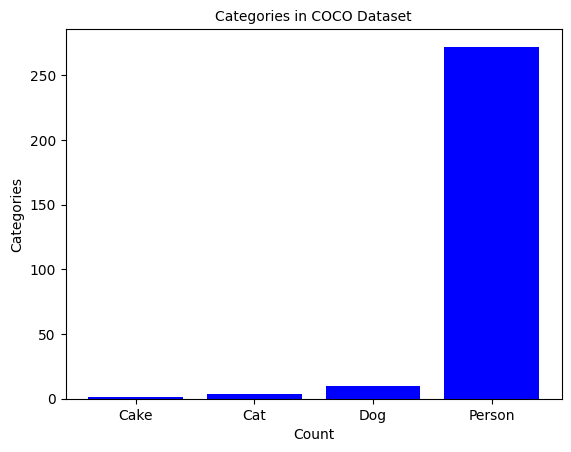

In [ ]:
# EDA for training data set
EDAbar(coco_train)

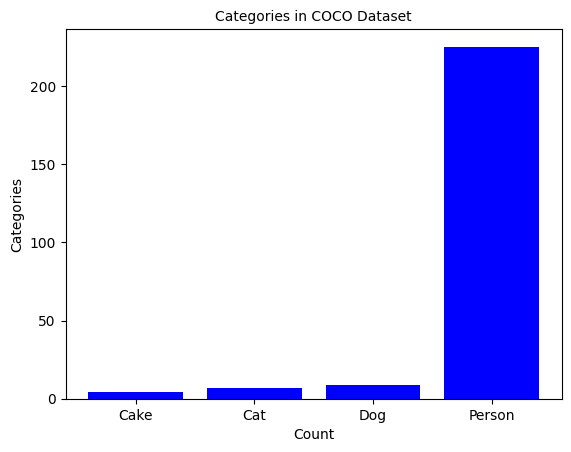

In [ ]:
# EDA for training data set
EDAbar(coco_val)

In [ ]:
target_classes = ["cake", "cat", "dog", "person"]
catIds_train = []
imgDict_train = []
imgIds_train = []

catIds_val = []
imgDict_val = []
imgIds_val = []

for class_name in target_classes:
    # training data set
    temp1 = coco_train.getCatIds(catNms=class_name)
    catIds_train += temp1
    temp2  = coco_train.getImgIds(catIds=temp1)
    if temp2 not in imgIds_train:
        imgIds_train += temp2
        imgDict_train += coco_train.loadImgs(temp2)

    # test data set
    temp3 = coco_val.getCatIds(catNms=class_name)
    catIds_val += temp3
    temp4 = coco_val.getImgIds(catIds=temp3)
    if temp4 not in imgIds_val:
        imgIds_val += temp4
        imgDict_val += coco_val.loadImgs(temp4)

In [ ]:
# Generate the list of file names for training and validation person images
train_images_list = []
val_images_list = []

In [ ]:
# count variable
count = 0

# Generate the masks for training images
for ID in imgIds_train:

    exImgIds = coco_train.getImgIds(imgIds=[ID])
    exImgDict = coco_train.loadImgs(exImgIds[np.random.randint(0, len(exImgIds))])[0]

    # Retrieve the annotation details
    annIds = coco_train.getAnnIds(imgIds=exImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # Generate the mask
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_train.annToMask(anns[i])

    if exImgDict['file_name'] not in train_images_list:
        train_images_list.append(exImgDict['file_name'])

    # Set the file path for the mask
    file_path = "/content/drive/MyDrive/RMiDS/coco2017/train-300/masked/" + exImgDict['file_name']

    # save the mask
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)
    count += 1

In [ ]:
# count variable
count = 0

# Generate the masks for validation images
for ID in imgIds_val:

    exImgIds = coco_val.getImgIds(imgIds=[ID])
    exImgDict = coco_val.loadImgs(exImgIds[np.random.randint(0, len(exImgIds))])[0]

    # retrieve the annotation details
    annIds = coco_val.getAnnIds(imgIds=exImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # Generate the mask
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    if exImgDict['file_name'] not in val_images_list:
        val_images_list.append(exImgDict['file_name'])

    # Set the file path for the mask
    file_path = "/content/drive/MyDrive/RMiDS/coco2017/validation-300/masked/" + exImgDict['file_name']

    # save the mask
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

    count += 1

In [ ]:
# copy required training files for the target class
src = '/content/drive/MyDrive/RMiDS/coco2017/train-300/data'
trg = '/content/drive/MyDrive/RMiDS/coco2017/train-300/filtered'

for fname in train_images_list:
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
# copy required validation files for the target class
src = '/content/drive/MyDrive/RMiDS/coco2017/validation-300/data'
trg = '/content/drive/MyDrive/RMiDS/coco2017/validation-300/filtered'

for fname in val_images_list:
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_filenames = self.get_matching_filenames()
        self.mask_filenames = self.get_matching_filenames()

    def get_matching_filenames(self):
        image_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.images_path)])
        mask_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.masks_path)])
        matching_files = list(image_files.intersection(mask_files))
        return matching_files

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_imgs = []
        batch_msks = []

        for filename in batch_filenames:
            image_path = os.path.join(self.images_path, filename + '.jpg')
            mask_path = os.path.join(self.masks_path, filename + '.jpg')

            image = Image.open(image_path)
            mask = Image.open(mask_path)

            if image.size != mask.size:
                raise ValueError(f"Incompatible dimensions for image {image_path} and mask {mask_path}")

            # Resize the images and masks to size 128x128
            image = image.resize((128, 128))
            mask = mask.resize((128, 128))

            # Convert the images and masks to arrays
            preproc_image = np.array(image)
            preproc_mask = np.array(mask)

            if len(preproc_image.shape) == 3 and preproc_image.shape == (128, 128, 3):
                preproc_image = preproc_image / 255.0
                preproc_mask = preproc_mask / 255.0

                batch_imgs.append(preproc_image)
                batch_msks.append(preproc_mask)

        return np.array(batch_imgs), np.array(batch_msks)

In [ ]:
imgs_path = '/content/drive/MyDrive/RMiDS/coco2017/train-300/filtered'
msks_path = '/content/drive/MyDrive/RMiDS/coco2017/train-300/masked'
batch_size = 8

# Create an instance of the CustomDataGenerator
train_generator = DataGen(imgs_path, msks_path, batch_size)

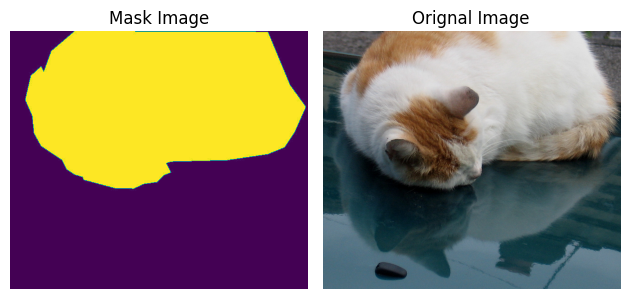

In [ ]:
# list of mask filenames
mask_fnames = [fname for fname in os.listdir(msks_path) if fname.endswith('.jpg')]

first_fname = mask_fnames[1]
image_fname = os.path.splitext(first_fname)[0] + '.jpg'

# plot the mask image
masked_image = Image.open(os.path.join(msks_path, first_fname))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.title('Mask Image')
plt.axis('off')

# plot the original image
org_image = Image.open(os.path.join(imgs_path, image_fname))
plt.subplot(1, 2, 2)
plt.imshow(org_image)
plt.title('Orignal Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
imgs_path = '/content/drive/MyDrive/RMiDS/coco2017/validation-300/filtered'
msks_path = '/content/drive/MyDrive/RMiDS/coco2017/validation-300/masked'
batch_size = 8

val_generator = DataGen(imgs_path, msks_path, batch_size)

In [ ]:
def down(input_tensor,
         no_filters,
         kernel_size=(3, 3),
         strides=(1, 1),
         padding="same",
         kernel_initializer="he_normal",
         max_pool_window=(2, 2),
         max_pool_stride=(2, 2)):

    conv = Conv2D(filters=no_filters, kernel_size=kernel_size, strides=strides,
                  activation=None, padding=padding,
                  kernel_initializer=kernel_initializer)(input_tensor)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(filters=no_filters, kernel_size=kernel_size, strides=strides,
                  activation=None, padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    pool = MaxPooling2D(pool_size=max_pool_window, strides=max_pool_stride)(conv)
    return conv, pool

In [ ]:
def bottle_neck(input_tensor,
                no_filters,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_initializer="he_normal"):

    conv = Conv2D(filters=no_filters, kernel_size=kernel_size, strides=strides,
                  activation=None, padding=padding,
                  kernel_initializer=kernel_initializer)(input_tensor)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(filters=no_filters, kernel_size=kernel_size, strides=strides,
                  activation=None, padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    return conv

In [ ]:
def up(input_tensor,
       no_filters,
       skip_connection,
       kernel_size=(3, 3),
       strides=(1, 1),
       upsampling_factor = (2,2),
       max_pool_window = (2,2),
       padding="same",
       kernel_initializer="he_normal"):

    conv = Conv2D(filters = no_filters, kernel_size= max_pool_window,
                  strides = strides, activation = None, padding = padding,
                  kernel_initializer=kernel_initializer
                  )(UpSampling2D(size = upsampling_factor)(input_tensor))
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    conv = concatenate([skip_connection, conv], axis = -1)
    conv = Conv2D(filters=no_filters, kernel_size=kernel_size, strides=strides,
                  activation=None, padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    conv = Conv2D(filters=no_filters, kernel_size=kernel_size, strides=strides,
                  activation=None, padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    conv = BatchNormalization(scale=True)(conv)
    conv = Activation("relu")(conv)
    return conv

In [ ]:
def output(input_tensor,
           padding="same",
           kernel_initializer="he_normal"):

    conv = Conv2D(filters=2, kernel_size=(3,3), strides=(1,1),
                  activation="relu", padding=padding,
                  kernel_initializer=kernel_initializer)(input_tensor)
    conv = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1),
                  activation="sigmoid", padding=padding,
                  kernel_initializer=kernel_initializer)(conv)
    return conv

In [ ]:
# Model
input_shape = (128,128,3)
filter_size = [64,128,256,512,1024]
inputs = Input(shape = input_shape)

d1 , p1 = down(input_tensor= inputs,
               no_filters=filter_size[0],
               kernel_size = (3,3),
               strides=(1,1),
               padding="same",
               kernel_initializer="he_normal",
               max_pool_window=(2,2),
               max_pool_stride=(2,2))

d2 , p2 = down(input_tensor= p1,
               no_filters=filter_size[1],
               kernel_size = (3,3),
               strides=(1,1),
               padding="same",
               kernel_initializer="he_normal",
               max_pool_window=(2,2),
               max_pool_stride=(2,2))

d3 , p3 = down(input_tensor= p2,
               no_filters=filter_size[2],
               kernel_size = (3,3),
               strides=(1,1),
               padding="same",
               kernel_initializer="he_normal",
               max_pool_window=(2,2),
               max_pool_stride=(2,2))

d4 , p4 = down(input_tensor= p3,
               no_filters=filter_size[3],
               kernel_size = (3,3),
               strides=(1,1),
               padding="same",
               kernel_initializer="he_normal",
               max_pool_window=(2,2),
               max_pool_stride=(2,2))

b = bottle_neck(input_tensor= p4,
                no_filters=filter_size[4],
                kernel_size = (3,3),
                strides=(1,1),
                padding="same",
                kernel_initializer="he_normal")

u4 = up(input_tensor = b,
        no_filters = filter_size[3],
        skip_connection = d4,
        kernel_size=(3, 3),
        strides=(1, 1),
        upsampling_factor = (2,2),
        max_pool_window = (2,2),
        padding="same",
        kernel_initializer="he_normal")

u3 = up(input_tensor = u4,
        no_filters = filter_size[2],
        skip_connection = d3,
        kernel_size=(3, 3),
        strides=(1, 1),
        upsampling_factor = (2,2),
        max_pool_window = (2,2),
        padding="same",
        kernel_initializer="he_normal")

u2 = up(input_tensor = u3,
        no_filters = filter_size[1],
        skip_connection = d2,
        kernel_size=(3, 3),
        strides=(1, 1),
        upsampling_factor = (2,2),
        max_pool_window = (2,2),
        padding="same",
        kernel_initializer="he_normal")

u1 = up(input_tensor = u2,
        no_filters = filter_size[0],
        skip_connection = d1,
        kernel_size=(3, 3),
        strides=(1, 1),
        upsampling_factor = (2,2),
        max_pool_window = (2,2),
        padding="same",
        kernel_initializer="he_normal")

oput = output(input_tensor=u1 ,
                padding = "same",
                kernel_initializer= "he_normal")

model = keras.models.Model(inputs = inputs , outputs = oput)
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][0

In [ ]:
# fit the model
r = model.fit(train_generator,validation_data=val_generator, epochs=20)

Epoch 1/20
35/35 [==============================] - 72s 1s/step - loss: 0.2984 - accuracy: 0.8938 - val_loss: 1.6818 - val_accuracy: 0.8736
Epoch 2/20
35/35 [==============================] - 12s 335ms/step - loss: 0.2697 - accuracy: 0.8938 - val_loss: 1.5458 - val_accuracy: 0.8736
Epoch 3/20
35/35 [==============================] - 11s 300ms/step - loss: 0.2586 - accuracy: 0.8938 - val_loss: 1.1938 - val_accuracy: 0.8736
Epoch 4/20
35/35 [==============================] - 11s 314ms/step - loss: 0.2553 - accuracy: 0.8938 - val_loss: 0.4638 - val_accuracy: 0.8736
Epoch 5/20
35/35 [==============================] - 12s 331ms/step - loss: 0.2518 - accuracy: 0.8938 - val_loss: 0.4374 - val_accuracy: 0.8736
Epoch 6/20
35/35 [==============================] - 12s 332ms/step - loss: 0.2458 - accuracy: 0.8938 - val_loss: 1.2032 - val_accuracy: 0.8736
Epoch 7/20
35/35 [==============================] - 10s 302ms/step - loss: 0.2415 - accuracy: 0.8938 - val_loss: 1.1799 - val_accuracy: 0.8736
Ep

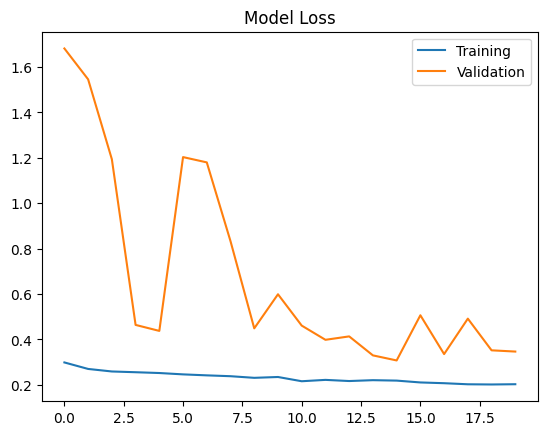

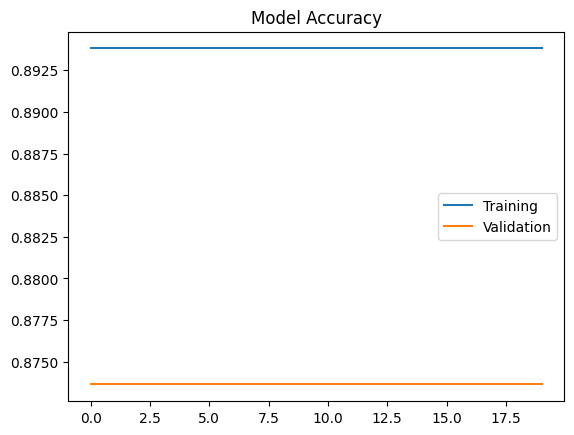

In [ ]:
# metrics
plt.figure()
plt.plot(r.history['loss'], label='Training')
plt.plot(r.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(r.history['accuracy'], label='Training')
plt.plot(r.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()

In [ ]:
# Get a sample batch from the validation data generator
sample_images, sample_masks = val_generator[0]

# Generate predictions on the sample batch
predictions = model.predict(sample_images)

1/1 [==============================] - 0s 20ms/step


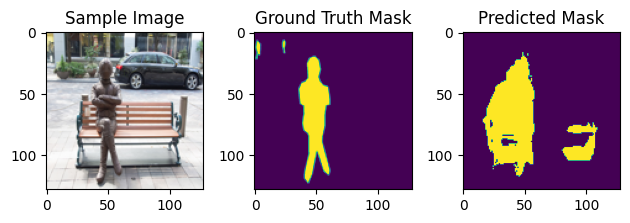

In [ ]:
threshold = 0.49
th_pred = (predictions > threshold).astype(np.uint8)

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3)

index = 1

# Plots
ax[0].imshow(sample_images[index])
ax[0].set_title('Sample Image')

ax[1].imshow(sample_masks[index])
ax[1].set_title('Ground Truth Mask')

ax[2].imshow(th_pred[index])
ax[2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()